# Validação Cruzada Time Series Split (teste)

In [ ]:
import eda
import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score

2025-08-01 08:12:32.126336: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754050352.137832 2828719 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754050352.141293 2828719 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754050352.151479 2828719 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754050352.151489 2828719 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754050352.151491 2828719 computation_placer.cc:177] computation placer alr

In [2]:
dados_manaus = eda.data_processing('Cotas extraidas',
                                   '1985-01-01',
                                   '2024-12-31',
                                   ['dados_diarios_estacao_14990000.csv'])
dados_manaus

,14990000
Data,
1985-01-01,2169.0
1985-01-02,2178.0
1985-01-03,2186.0
1985-01-04,2194.0
1985-01-05,2201.0
...,...
2024-12-27,1751.0
2024-12-28,1769.0
2024-12-29,1785.0


In [3]:
def create_multi_step_dataset(series, janela, n_steps):
    X, y = [], []
    for i in range(len(series) - janela - n_steps + 1):
        X.append(series[i:i+janela])
        y.append(series[i+janela:i+janela+n_steps])
    return np.array(X), np.array(y)

In [4]:
def criar_lstm(units: int, janela: int, n_steps: int, activation='tanh'):
    model = keras.models.Sequential([
        keras.layers.Input(shape=(janela, 1)),
        keras.layers.LSTM(units, activation=activation),
        keras.layers.Dense(n_steps)
    ])

    model.compile(optimizer='adam', loss='mse', metrics=[keras.metrics.MeanAbsoluteError()])

    return model

In [5]:
janela = 15
steps = 15
X, y = create_multi_step_dataset(dados_manaus['14990000'].values, janela, steps)

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)
r2_list = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    x_train_raw, x_test_raw = X[train_idx], X[test_idx]
    y_train_raw, y_test_raw = y[train_idx], y[test_idx]

    # Cria novo scaler a cada fold
    scaler_x = MinMaxScaler()
    x_train_scaled = scaler_x.fit_transform(x_train_raw)
    x_test_scaled = scaler_x.transform(x_test_raw)

    scaler_y = MinMaxScaler()
    y_train_scaled = scaler_y.fit_transform(y_train_raw)

    # Treina e avalia
    modelo = criar_lstm(15, janela, steps)
    modelo.fit(x_train_scaled, y_train_scaled, epochs=50, verbose=0)

    y_pred = modelo.predict(x_test_scaled)
    y_pred_inverso = scaler_y.inverse_transform(y_pred)

    r2 = r2_score(y_test_raw, y_pred_inverso)
    r2_list.append(r2)

    print(f"Fold {fold+1} — R²: {r2:.4f}")

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fold 1 — R²: 0.9892
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Fold 2 — R²: 0.9915
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fold 3 — R²: 0.9949
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Fold 4 — R²: 0.9956
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Fold 5 — R²: 0.9955


In [11]:
r2_mean = np.mean(r2_list)
r2_std = np.std(r2_list)

print(f"R² = {r2_mean:.4f} +- {r2_std:4f}")

R² = 0.9934 +- 0.002556


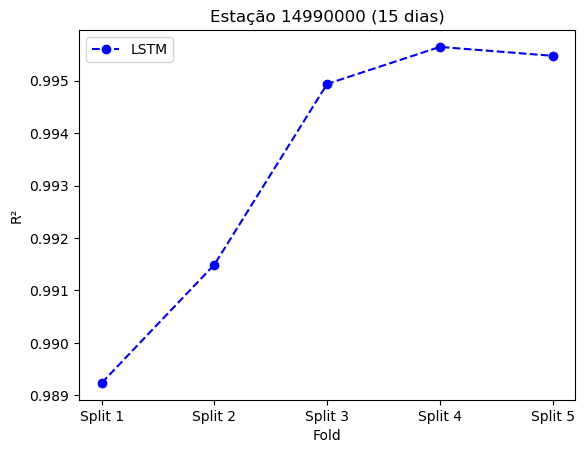

In [27]:
plt.plot(r2_list, 'bo', linestyle='--', label='LSTM')
plt.legend()
plt.xticks([0, 1, 2, 3, 4], [f'Split {i+1}' for i in range(5)])
plt.xlabel('Fold')
plt.ylabel('R²')
plt.title(f'Estação 14990000 ({steps} dias)')
plt.show()